<h1>Local setup with Anaconda</h1>
<p>You will need the following packages:<p>
<ol>
    <li><b>networkx:</b> <code>conda install networkx</code></li><br>
    <li><b>hiveplot:</b> <code>conda install -c conda-forge hiveplot</code></li><br>
    <li><b>nxviz:</b> <code>conda install -c conda-forge nxviz</code></li><br>
    <li><a href="https://github.com/taynaud/python-louvain"><b>python-louvain:</b></a><code>conda install python-louvain</code></li>
<ol>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

import networkx as nx
from nxviz import MatrixPlot, ArcPlot, CircosPlot
from hiveplot import HivePlot
import community 

%matplotlib inline

<h1>Loading datasets</h1>
<p>There are different file formats for storing network data and in most cases these data are divided into two files: one file contains edges and their attributes while the other contains nodes and their attributes.<br>
When loading the dataset, you have to decide which class of graphs to use based on the network structure you want to represent.
</p>
<p>
NetworkX provides the following classes:
<ul>
<li> Graph: undirected graphs with self loops </li>
<li> DiGraph: directed graphs with self loops </li>
<li> MultiGraph: undirected graphs with self loops and parallel edges </li>
<li> MultiDiGraph: directed graphs with self loops and parallel edges </li>
<li> OrderedGraphs: consistently ordered graphs </li>
</ul>
</p>
<a href="http://konect.uni-koblenz.de/networks/moreno_seventh"><h2>Seventh graders dataset</h2></a>
<p>This directed network contains proximity ratings between students from 29 seventh grade students from a school in Victoria. Among other questions the students were asked to nominate their preferred classmates for three different activities. A node represents a student. An edge between two nodes shows that the left student picked the right student as his answer. The edge weights are between 1 and 3 and show how often the left student chose the right student as his favourite.</p>

In [8]:
# Read the edge list
df = pd.read_csv('data/out.moreno_seventh_seventh', skiprows=2, header=None, sep=' ')
df.columns = ['student1', 'student2', 'count']

# Read the node metadata
nodeAttributes = pd.read_csv('data/ent.moreno_seventh_seventh.student.gender',header=None)
nodeAttributes.index += 1
nodeAttributes.columns = ['gender']
    
# Construct graph from edge list.
G = nx.DiGraph()
for row in df.iterrows():
    G.add_edge(row[1]['student1'], row[1]['student2'], count=row[1]['count'])
    
# Add node attributes
for n in G.nodes():
    (G.nodes[n])['gender'] = nodeAttributes.iloc[n-2]['gender']

print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 29
Number of edges: 376
Average in degree:  12.9655
Average out degree:  12.9655


<h3>Basic operations</h3>
<p>In the networkx implementation, graph objects store their data in dictionaries.</p>
<p>Graph.nodes -> {ID : dictionary of attributes}</p>
<p>Graph.edges -> {(ID1,ID2) : dictionary of attributes}</p>

In [40]:
#The G.nodes() returns an object of type Nodedataview
#we can cast it to a list in order to perform list-slicing and extract subsets of the graph.
#The optional parameter data lets you see nodes metadata.
list(G.nodes(data=True))[:3]

[(1, {'gender': 'female'}), (2, {'gender': 'male'}), (3, {'gender': 'male'})]

In [41]:
#count the number of nodes
len(G.nodes())

29

In [42]:
list(G.edges(data=True))[:3]

[(1, 2, {'count': 1}), (1, 3, {'count': 1}), (1, 4, {'count': 2})]

In [48]:
#access an attribute of a single node
G.nodes[1]['gender']

'female'

<p>General useful patterns are:
<ul>
    <li><code>[n2 for n1, n2, d in G.edges(data=True)]</code></li><br>
    <li><code>[d['attr'] for n, d in G.nodes(data=True)]</code></li>
</ul>
</p>

In [49]:
#wer can see how many students have "unrequited" friendships
len([(n1, n2) for n1, n2 in G.edges() if not G.has_edge(n2, n1)])

124

<h1>Graph visualization</h1>
<p>If the network is large, visualizations begin to look like <b>hairballs</b> and you can not get any useful information about its features. <br> So there are other ways to visualize networks following a <b>rational visualization approach</b>: arc plots, circus plots and hive plots. <br> The principle behind <b>rational visualization</b> is to prioritize the placement of nodes in a certain way and then look at the edges and how they are structured according to the organization of the nodes.</p>

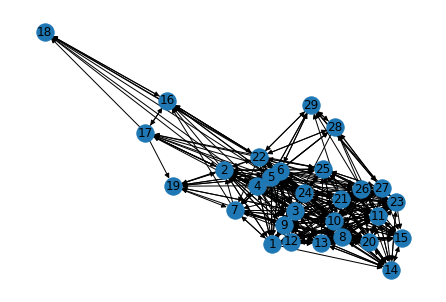

In [52]:
nx.draw(G, with_labels=True)

<h2>Arc plot</h2>
<p>In arc diagrams, nodes are displayed along a single axis and links are represented with arcs.<br>Nodes can be grouped or ordered by a criteria in order to visualize the <b>density</b> of the connections between groups.</p>

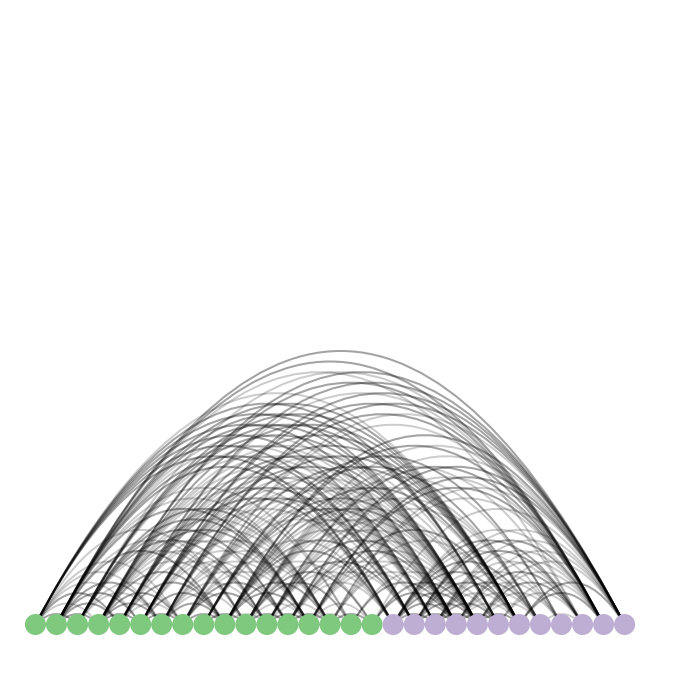

In [152]:
a = ArcPlot(G, node_color='gender', node_grouping='gender')
a.draw()

<h2>Circos plot</h2>
<p>This visualization helps us highlight nodes that there are <b>poorly connected</b>, and others that are <b>strongly connected</b>.</p>

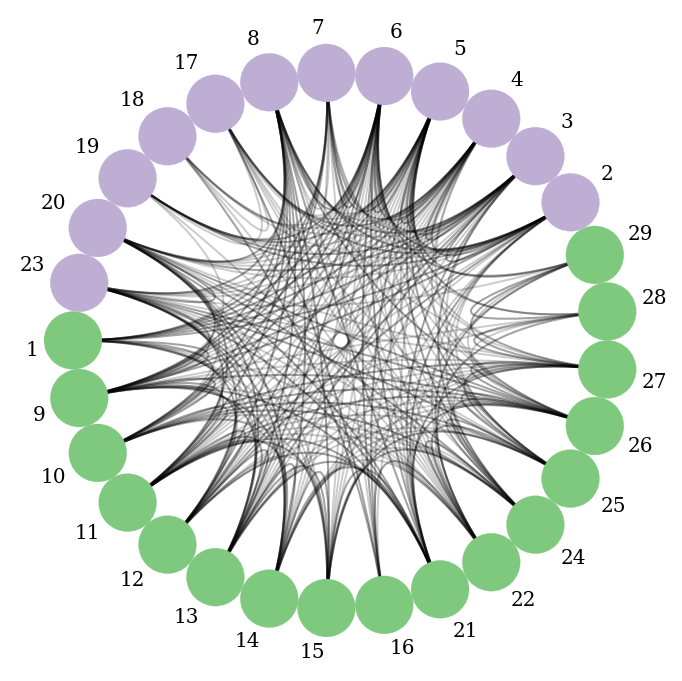

In [149]:
c = CircosPlot(G, node_color='gender', node_grouping='gender', node_labels=True)
c.draw()

<h2>Hiveplots</h2>
<p>Hive plots allow us to divide our nodes into sub-groups, and visualize the within- and between-group connectivity.</p>

In [119]:
nodes = dict()
nodes['male'] = [n for n,d in G.nodes(data=True) if d['gender'] == 'male']
nodes['female'] = [n for n,d in G.nodes(data=True) if d['gender'] == 'female']

edges = dict()
edges['group1'] = G.edges(data=True)

nodes_cmap = dict()
nodes_cmap['male'] = 'blue'
nodes_cmap['female'] = 'red'

edges_cmap = dict()
edges_cmap['group1'] = 'black'

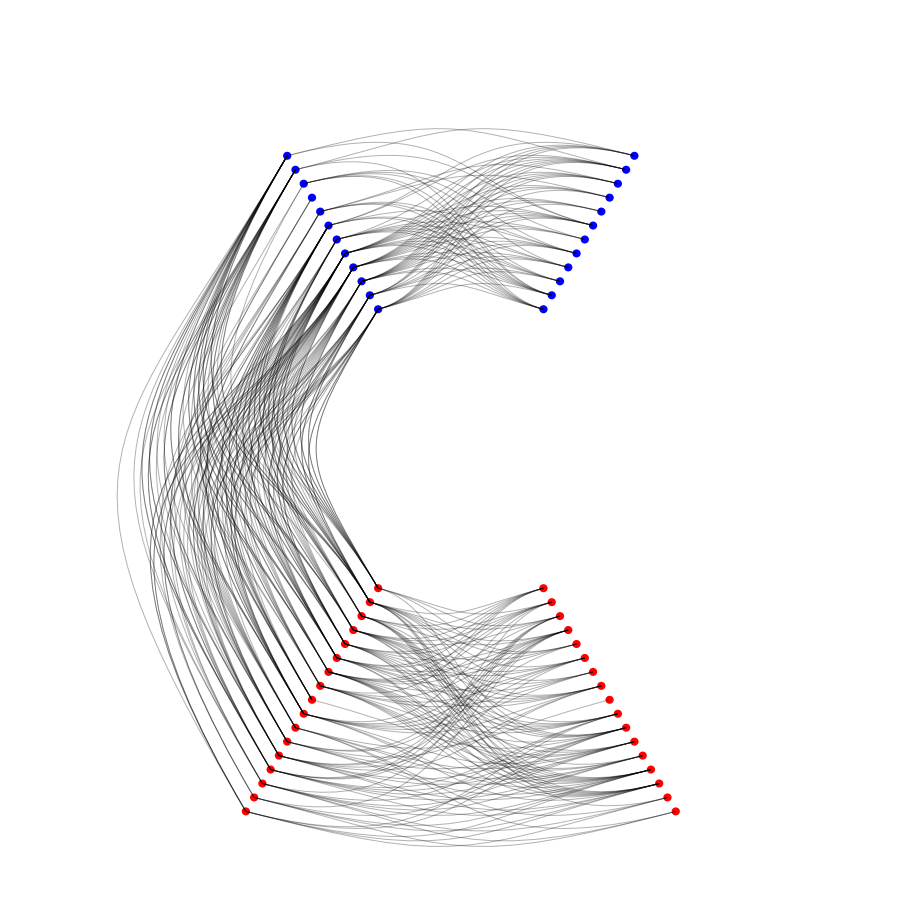

In [120]:
h = HivePlot(nodes, edges, nodes_cmap, edges_cmap)
h.draw()

<h1>Centrality measures</h1>

<p>The centrality measures are used to identify and classify the most important nodes in the network.<br>Some of the applications are finding the most influential people in a social network or identifying the super spreaders of a disease.</p>

<a href="http://konect.uni-koblenz.de/networks/moreno_train"><h2>Train bombing dataset</h2></a>
<p>This undirected network contains contacts between suspected terrorists involved in the train bombing of Madrid on March 11, 2004 as reconstructed from newspapers. A node represents a terrorist and an edge between two terrorists shows that there was a contact between the two terroists. The edge weights denote how 'strong' a connection was. This includes friendship and co-participating in training camps or previous attacks.</p>

In [53]:
df = pd.read_csv('data/out.moreno_train_train', skiprows=2, header=None, sep=' ')
df.columns = ['terrorist1', 'terrorist2','weight']
G = nx.from_pandas_edgelist(df, source='terrorist1', target='terrorist2',edge_attr='weight')
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 64
Number of edges: 243
Average degree:   7.5938


<p>We can see with the following visualization which are the most influential and active terrorists.</p>

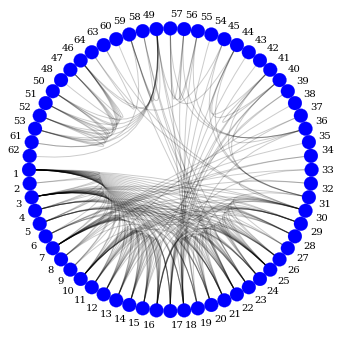

In [54]:
c = CircosPlot(G, node_labels=True)
c.draw()

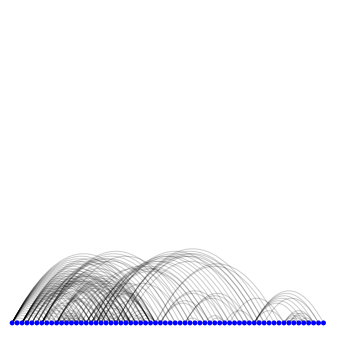

In [56]:
a = ArcPlot(G)
a.draw()

In [9]:
sorted(G.nodes(),key=lambda x:len(list(G.neighbors(x))), reverse=True)[0:5]

[1, 3, 7, 10, 25]

In [3]:
sorted(nx.degree_centrality(G).items(), key=lambda x: x[1], reverse=True)[:5]

[(1, 0.4603174603174603),
 (3, 0.42857142857142855),
 (7, 0.3492063492063492),
 (10, 0.2857142857142857),
 (25, 0.2698412698412698)]

In [7]:
sorted(nx.closeness_centrality(G).items(), key=lambda x: x[1], reverse=True)[:5]

[(1, 0.5833333333333334),
 (3, 0.5727272727272728),
 (25, 0.5080645161290323),
 (7, 0.5),
 (22, 0.49606299212598426)]

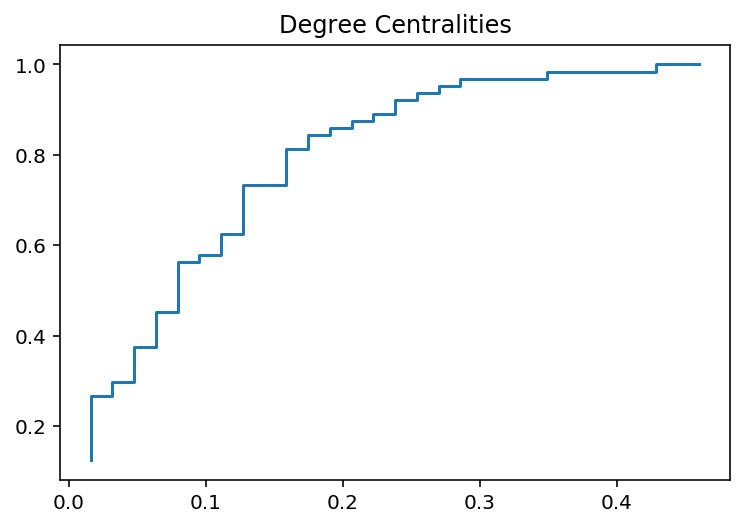

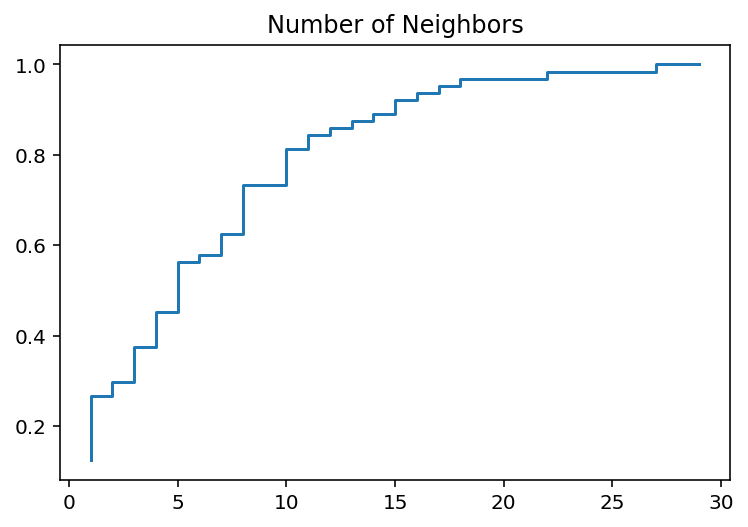

In [240]:
fig = plt.figure(0)
ecdf = sm.distributions.ECDF(degree_centralities)
x = np.sort(degree_centralities)
y = ecdf(x)
plt.step(x, y)
plt.title('Degree Centralities')
fig = plt.figure(1)
neighbors = [len(list(G.neighbors(node))) for node in G.nodes()]
ecdf = sm.distributions.ECDF(neighbors)
x = np.sort(neighbors)
y = ecdf(x)
plt.step(x, y)
plt.title('Number of Neighbors')
plt.show()

Text(0, 0.5, 'Number of Neighbors')

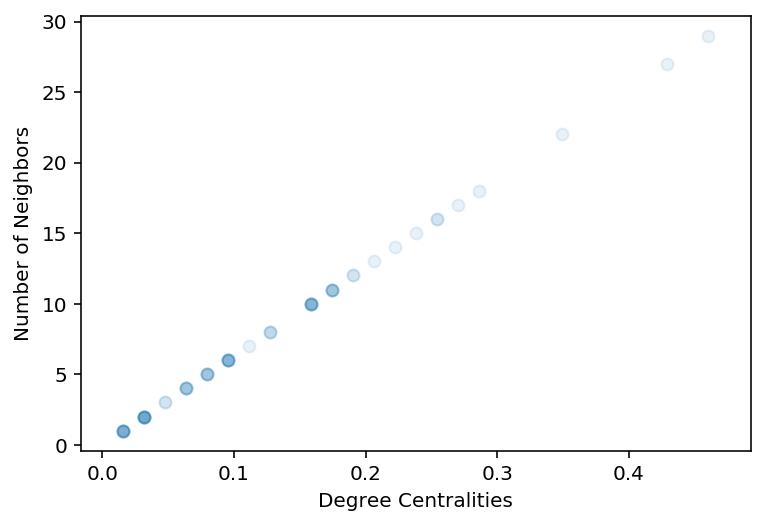

In [241]:
fig = plt.figure(2)
plt.scatter(degree_centralities, neighbors, alpha=0.1)
plt.xlabel('Degree Centralities')
plt.ylabel('Number of Neighbors')

In [ ]:
nx.has_path(G, 400, 1)
nx.shortest_path(G, 4, 400)

In [29]:
df = pd.read_csv('data/out.moreno_train_train', skiprows=2, header=None, sep=' ')
df.columns = ['surf1', 'surf2','weight']
G = nx.from_pandas_edgelist(df, source='surf1', target='surf2',edge_attr='weight')
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 64
Number of edges: 243
Average degree:   7.5938


In [84]:
import community

partition = community.best_partition(G)

for n in G.nodes():
    G.nodes[n]['group'] =  partition[n]

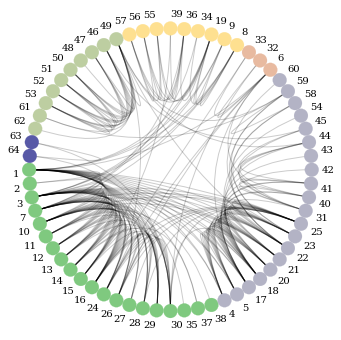

In [39]:
c = CircosPlot(G, node_color='group', node_grouping='group', node_labels=True)
c.draw()

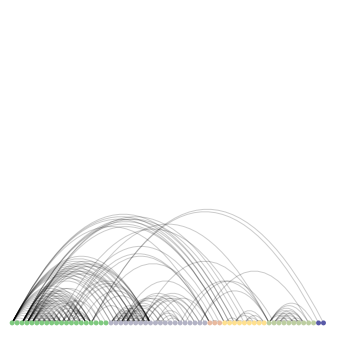

In [41]:
a = ArcPlot(G, node_color='group', node_grouping='group', node_labels=True)
a.draw()

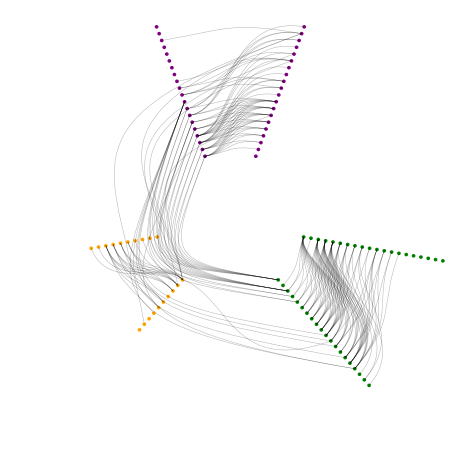

In [83]:
colors=['green','purple','red','blue','orange','yellow']
#groups=list(pd.Series(partition).unique())
groups=list(pd.Series(partition).value_counts()[:3].index)
nodes = dict()
nodes_cmap = dict()
for i in groups:
    nodes[i] = [n for n,d in G.nodes(data=True) if d['group'] == i]
    nodes_cmap[i] = colors[i]

edges = dict()
edges['group1'] = G.subgraph([n for n in G.nodes() if (G.nodes()[n]['group'] in groups)]).edges(data=True)

edges_cmap = dict()
edges_cmap['group1'] = 'black'

h = HivePlot(nodes, edges, nodes_cmap, edges_cmap)
h.draw()

In [8]:
pred_jc = nx.jaccard_coefficient(G)
pred_jc_dict = {}
for u,v,p in pred_jc:
    pred_jc_dict[(u,v)] = p
sorted(pred_jc_dict.items(),key=lambda x:x[1], reverse=True)[:10]

[((42, 43), 1.0),
 ((28, 30), 0.6153846153846154),
 ((2, 9), 0.5),
 ((34, 35), 0.5),
 ((35, 37), 0.5),
 ((61, 62), 0.5),
 ((47, 49), 0.45454545454545453),
 ((26, 27), 0.4),
 ((11, 28), 0.38461538461538464),
 ((12, 28), 0.38461538461538464)]

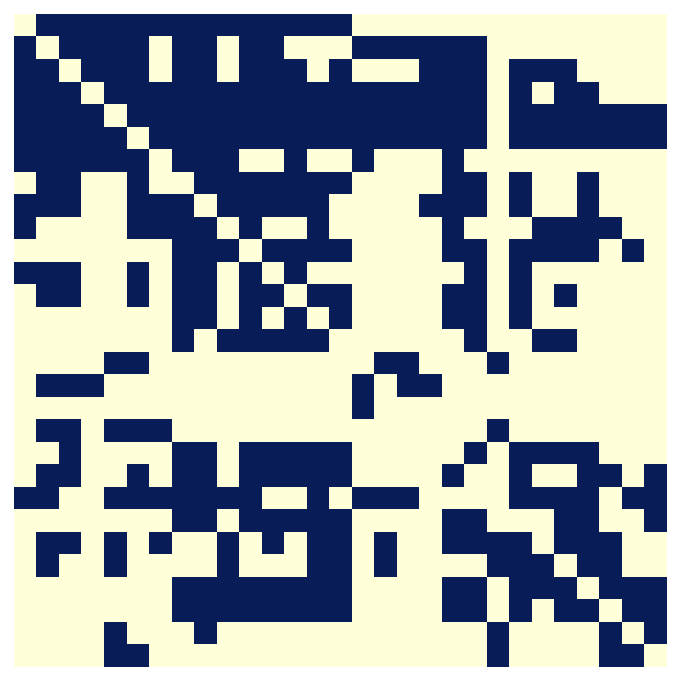

In [146]:
m = MatrixPlot(G)
m.draw()
plt.show()

<b><i>The hearth of a graph lies in its edges, not in its nodes</i></b><br>
<i>- John Quackenbush Harvard School of Public Health</i>